In [1]:
import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob
import os
import re
import sys 

In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/polyATAC/atac_notail_20250730_peak.h5ad')
min_cells = int(adata.shape[0] * 0.05)
sc.pp.filter_genes(adata, min_cells=min_cells)
adata.var["name"]  = adata.var_names
split_interval = adata.var["name"].str.split("-", expand=True)
adata.var["chr"] = split_interval[0]
adata.var["start"] = split_interval[1].astype(int)
adata.var["end"] = split_interval[2].astype(int)
mask = adata.var["chr"].str.startswith("chr")
adata = adata[:, mask].copy()

In [3]:
scvi.data.add_dna_sequence(
            adata,
            genome_name="mm10",
            genome_dir="/data/jiangjunyao/software/scbasset/data",
            chr_var_key="chr",
            start_var_key="start",
            end_var_key="end",
            install_genome = False
        )

Working...: 100%|██████████| 20/20 [00:01<00:00, 11.95it/s]


In [4]:
adata

AnnData object with n_obs × n_vars = 60355 × 37083
    obs: 'nCount_RNA', 'nFeature_RNA', 'Batch', 'ct_leiden', 'leiden', 'cell', 'nCount_Peak_ct', 'nFeature_Peak_ct', 'barcodes', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_Activity_DAR', 'nFeature_Activity_DAR', 'pgen', 'germ', 'detection', 'RNA_snn_res.0.8', 'seurat_clusters', 'RNA_snn_res.2', 'celltype', 'RNA_snn_res.2.5', 'nCount_TFActivity_all_peak', 'nFeature_TFActivity_all_peak'
    var: 'count', 'percentile', 'n_cells', 'name', 'chr', 'start', 'end'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'dna_sequence', 'dna_code'

In [5]:
##start train
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")
bas = scvi.external.SCBASSET(bdata)
bas.train(precision=16,batch_size=256,max_epochs=500)
latent = bas.get_latent_representation()
adata.obsm["X_scbasset"] = latent

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Using column names from columns of adata.obsm['dna_code']                                                 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/data/jiangjunyao/miniconda3/envs/normal/lib/python3.9/site-packages/lightning/fabric/connector.py:558: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/data/jiangjunyao/miniconda3/envs/normal/lib/python3.9/site-packages/lightning/pytorch/plugins/precision/amp.py:54: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has

Epoch 500/500: 100%|██████████| 500/500 [1:55:32<00:00, 13.90s/it, v_num=1, train_loss_step=0.296, train_loss_epoch=0.317]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [1:55:32<00:00, 13.87s/it, v_num=1, train_loss_step=0.296, train_loss_epoch=0.317]


<AxesSubplot: xlabel='epoch'>

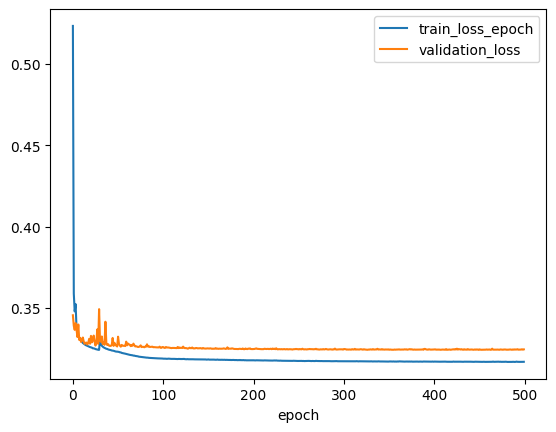

In [6]:
fig, ax = plt.subplots()
bas.history_["train_loss_epoch"].plot(ax=ax)
bas.history_["validation_loss"].plot(ax=ax)

In [7]:
sc.pp.neighbors(adata, use_rep="X_scbasset")
sc.tl.umap(adata,min_dist=0.5)

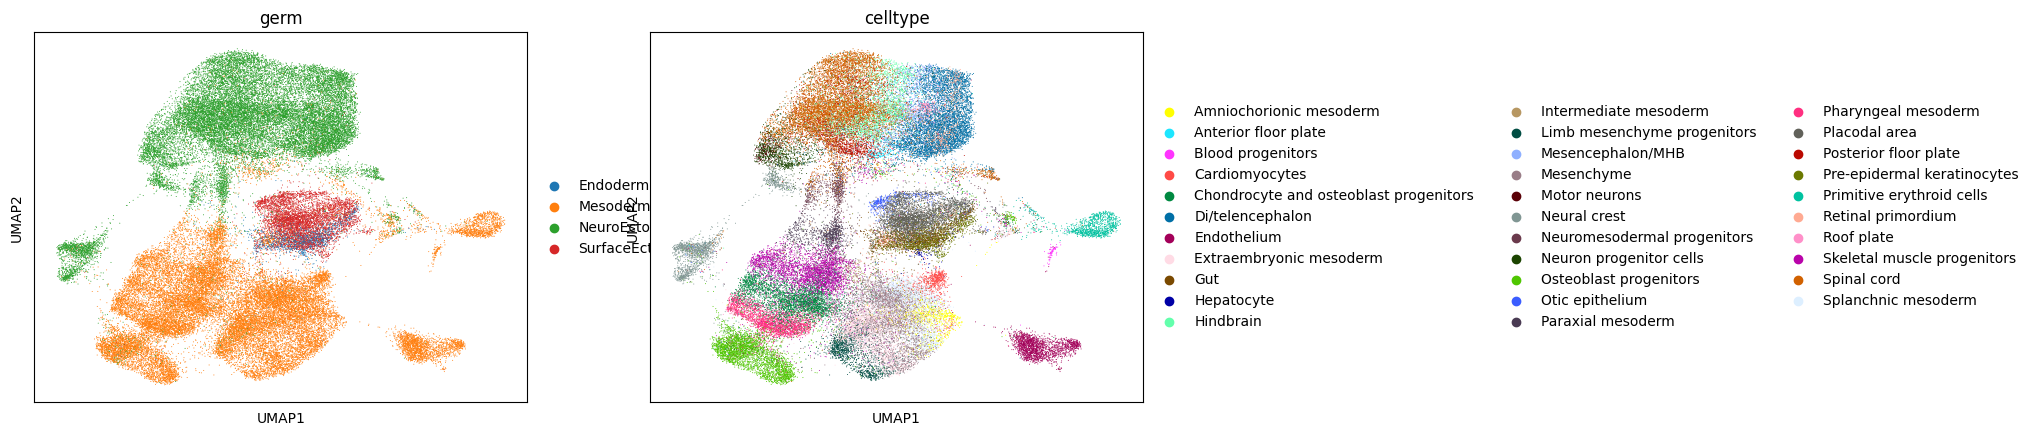

In [8]:
sc.pl.umap(adata,color=['germ','celltype'])

In [12]:
latent_df = pd.DataFrame(adata.obsm['X_scbasset'])
latent_df.index = adata.obs_names
latent_df.to_csv('/data/jiangjunyao/polyATAC/multiomi/scbasset_latent.csv')

In [13]:
latent_df = pd.DataFrame(adata.obsm['X_umap'])
latent_df.index = adata.obs_names
latent_df.to_csv('/data/jiangjunyao/polyATAC/multiomi/scbasset_umap.csv')

In [14]:
pd.DataFrame(adata.obsm['X_scbasset']).shape

(60355, 32)